In [1]:
import msprime, tskit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from IPython.display import SVG
from matplotlib.patches import Polygon

# 4. Analyses with tskit

At the end of the previous worksheet, we learnt how to convert a tree sequence's mutational information back into a VCF sequence file. This allows us to use software like `scikit-allel`, `plink`, `bcftools` and `vcftools` on our simulated datasets.

However, there's a lot we can do entirely within `tskit`, and these native methods are often quicker and more efficient than methods that work with the sequence data.
Since tree sequences also contain information about ancestry and times, there are also many analyses we can *only* perform on tree sequences.
We'll learn about some of these methods in this worksheet.

 - [4.1: Site statistics](#4.1SiteStatistics)
 - [4.2: Branch statistics](#4.2BranchStatistics)
 - [4.3: Simplify](#4.3Simplify)
 - [4.4: Population and individual-based ancestry](#4.4PopulationBasedAncestry)

###  A simulated tree sequence to use

First, we'll simulate some tree sequence datasets with mutations to use in the rest of this notebook.

 <img src="pics/worksheet4-demography.png" width="500" height="500">

Here's a simple model of admixture in which two populations split 1000 generations ago from an ancestral population, and the third is formed after an admixture event 100 generations ago.
One of the modern-day populations is larger than the other two. 

In [2]:
demography = msprime.Demography()
demography.add_population(name="SMALL", initial_size=2000)
demography.add_population(name="BIG", initial_size=5000)
demography.add_population(name="ADMIX", initial_size=2000)
demography.add_population(name="ANC", initial_size=5000)
demography.add_admixture(
    time=100, derived="ADMIX", ancestral=["SMALL", "BIG"],
    proportions=[0.5, 0.5])
demography.add_population_split(
    time=1000, derived=["SMALL", "BIG"], ancestral="ANC")
demography.debug()

In [3]:
ts = msprime.sim_ancestry(
    samples={"SMALL": 100, "BIG": 100, "ADMIX" : 100},
    demography=demography,
    random_seed=2432,
    sequence_length=5e7,
    recombination_rate=1e-8
)
ts = msprime.sim_mutations(ts, rate=1e-8, random_seed=6151)
ts

We'll also use a tree sequence simulated using a model of a simple selective sweep.

In [4]:
pop_size=5000
seq_length=50_000_000

# Specify sweep parameters.
sweep_model = msprime.SweepGenicSelection(
    position=seq_length/2,
    start_frequency=0.0001,
    end_frequency=0.9999,
    s=0.25,
    dt=1e-6
)

# Simulate sweep genealogies.
ts_sweep = msprime.sim_ancestry(
    100,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=pop_size,
    sequence_length=seq_length,
    recombination_rate=1e-8,
    random_seed=1234,
    )

# Add finite-site mutations.
ts_sweep = msprime.sim_mutations(
    ts_sweep, rate=1e-8, random_seed=4321)
ts_sweep

<a id='4.1SiteStatistics'></a>
## 4.1 Site statistics

Suppose you have $n$ sequences typed at $m$ different sites...

```
   ...GTAACGCGATAAGAGATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGAGATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGAAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGTAATAGCGTA...
   ...GTAACGCGATAAGATATTAGCCCAAAAACACAGACATGGTAATAGCGTA...
```

...and you want to calculate mean pairwise diversity on these samples, i.e.

$$ \pi = \dfrac{1}{n(n-1)/2}\sum_{i=1}^{n-1} \sum_{j=i+1}^n k_{ij}, $$

where $k_{ij}$ is the number of sites at which sequences $i$ and $j$ carry a different allele.
The scaling of this procedure is

$$ O\left( n^2 m \right) $$

ie. quadratic in the number of samples $n$, and linear in the number of sites $m$.
However, there is an equivalent way of performing this calculation by assigning weights to the sample nodes, and propagating these values further up the tree using a 'summary function' at each mutation.

 <img src="pics/worksheet4-node-weights.jpeg" width="350" height="350">
 
 This is what `tskit` calls a *site statistic* calculation, and because the operation is of order
 
 $$ O\left( n + \rho m (\log(n))^2 \right)  << O\left( n^2 m \right), $$
 
the calculation is quick to run, especially on large datasets:

 <img src="pics/worksheet4-stat-speed.jpeg" width="500" height="500">

See the following paper for more details, especially if you are interested in coming up with tree sequence statistics of your own.

Peter Ralph, Kevin Thornton, Jerome Kelleher, Efficiently Summarizing Relationships in Large Samples: A General Duality Between Statistics of Genealogies and Genomes, Genetics, Volume 215, Issue 3, 1 July 2020, Pages 779–797, https://doi.org/10.1534/genetics.120.303253

### The basic syntax: (nucleotide diversity)

`tskit` uses very similar syntax for all of its inbuilt statistics, so we'll explore the options using `diversity()` as an example.


In [5]:
ts.diversity()

np.float64(0.00020264610907067793)

By default, `tskit` presents a normalised version of the statistic  scaled by the length of the region represented in `ts`. This allows you to make comparisons between different tree sequences that may be of different lengths. However, this isn't how all other genetic software computes diversity -- if you wish to disable `tskit`'s default behaviour, use the `span_normalise` argument.

In [6]:
div = ts.diversity(span_normalise=False)
div[()]

np.float64(10132.305453533896)

### Calculating statistics on subsets of the samples

Remember that this dataset consists of samples from three contemporary populations here, of different sizes. We’d expect them to each have different diversity levels, and for these to differ from the overall (sample-wide) diversity rate. We can get this information out by specifying each of these with the `sample_nodes` argument.

A quick and simple way to get all of the sample node IDs from a particular population is to use the `samples()` method. For instance, the following code returns a numpy array holding all of the sample node IDs from 'population 0':

In [7]:
ts.samples(0)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

By cross-checking against the population table, we can see the population IDs of all the populations in our simulated demography.

In [8]:
ts.tables.populations

id,metadata
0,"{'description': '', 'name': 'SMALL'}"
1,"{'description': '', 'name': 'BIG'}"
2,"{'description': '', 'name': 'ADMIX'}"
3,"{'description': '', 'name': 'ANC'}"


Suppose we wanted to calculate the value of the diversity statistic for each of the three contemporary populations in our dataset ('SMALL', 'BIG' and 'ADMIX'), as well as for the pooled set of samples:

In [9]:
samples_of_interest=[ts.samples(population=0),
                          ts.samples(population=1),
                          ts.samples(population=2),
                          ts.samples()]
ts.diversity(sample_sets=samples_of_interest)

array([0.00016878, 0.00020063, 0.00019961, 0.00020265])

The output is a 1-dimensional numpy array, where each element is a diversity statistic value for one of the sample sets we specified.
Nucleotide diversity is lowest in the set of samples from the small population, and largest in the pooled set of samples, as you'd expect.

Note that you can use any list of node IDs as inputs to `sample_sets`. This may be useful if your samples of interest correspond to something other than populations (for instance, samples that hold some phenotype of interest).

In [10]:
ts.diversity(sample_sets=[[12, 14, 18, 7, 8],
                          [23, 19, 10]])

array([0.00016337, 0.00017956])

### Genome scans

So far, we’ve just been calculating statistics summarising diversity values along the entire simulated genome. However, in many cases, we might be more interested in how diversity varies along the genome. We can do this using the `windows` argument.

We specify the start and end points of the sequence, and the locations of the breakpoints between each window. For instance, suppose we wanted to specify some windows of length 1Mb covering our 50Mb chromosome:

In [11]:
breakpoints = [i*1e6 for i in range(0, 50 + 1)]
print(breakpoints)

[0.0, 1000000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0, 10000000.0, 11000000.0, 12000000.0, 13000000.0, 14000000.0, 15000000.0, 16000000.0, 17000000.0, 18000000.0, 19000000.0, 20000000.0, 21000000.0, 22000000.0, 23000000.0, 24000000.0, 25000000.0, 26000000.0, 27000000.0, 28000000.0, 29000000.0, 30000000.0, 31000000.0, 32000000.0, 33000000.0, 34000000.0, 35000000.0, 36000000.0, 37000000.0, 38000000.0, 39000000.0, 40000000.0, 41000000.0, 42000000.0, 43000000.0, 44000000.0, 45000000.0, 46000000.0, 47000000.0, 48000000.0, 49000000.0, 50000000.0]


In [12]:
div = ts.diversity(sample_sets=samples_of_interest, windows=breakpoints)
print("Dimensions of the output:", div.shape, "\n")
print("Diversity values over the first 10 windows in each sample set:")
print(div[:10,:])

Dimensions of the output: (50, 4) 

Diversity values over the first 10 windows in each sample set:
[[0.00013413 0.00017975 0.00017326 0.00017541]
 [0.00012816 0.00015817 0.00016614 0.00016266]
 [0.0001566  0.00018443 0.00018554 0.0001883 ]
 [0.00017575 0.00021751 0.00020456 0.00021195]
 [0.00016071 0.00018861 0.00019052 0.00019944]
 [0.00017245 0.00018715 0.00018211 0.00019068]
 [0.0001832  0.00021782 0.00020818 0.00021359]
 [0.00014416 0.00019749 0.00018297 0.0001875 ]
 [0.00016066 0.00018454 0.00019357 0.00018953]
 [0.00016737 0.00019592 0.00019465 0.00019873]]


The output is a 50 by 4 array, one row for each of our specified windows. Each element of the row holds diversity value in some particular window amongst one of our sample sets. Let’s plot these:

Text(0.5, 1.0, 'Windowed diversity values')

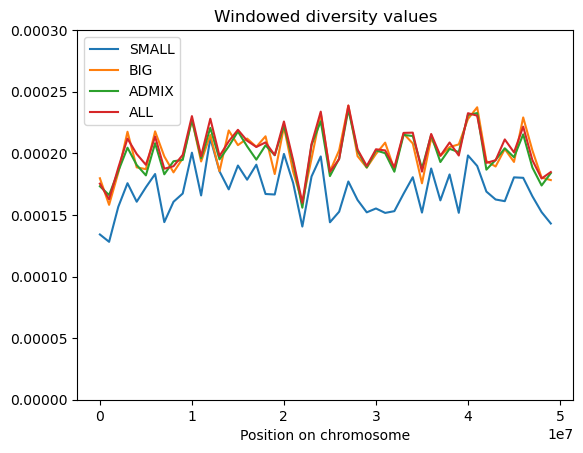

In [13]:
names_to_plot = ['SMALL', 'BIG', 'ADMIX', 'ALL']
lines = plt.plot(breakpoints[:-1], div)
plt.legend(lines, names_to_plot);
plt.xticks()
plt.xlabel("Position on chromosome")
plt.ylim(0,0.0003)
plt.title("Windowed diversity values")

Because `ts` holds a sample simulated under a selectively neutral simulation, any variation we do see along the genome is just statistical noise. 
What if we look at `ts_sweep` instead?

Text(0.5, 1.0, 'Windowed diversity values')

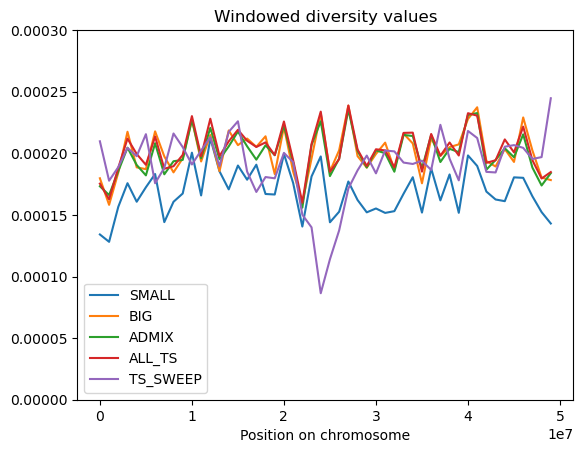

In [14]:
names_to_plot = ['SMALL', 'BIG', 'ADMIX', 'ALL_TS', 'TS_SWEEP']
div_sweep = ts_sweep.diversity(windows=breakpoints)
all_divs = np.append(div, np.reshape(div_sweep, newshape=(-1,1)), axis=1)
lines = plt.plot(breakpoints[:-1], all_divs)
plt.legend(lines, names_to_plot);
plt.xticks()
plt.xlabel("Position on chromosome")
plt.ylim(0,0.0003)
plt.title("Windowed diversity values")

### Multi-way statistics

Diversity is an example of a 'one-way' statistic. All of the samples are exchangeable in the calculation: if we were to re-label one of the samples with another label, we’d still get the same statistic.

Other examples of one-way statistics are:

 - [allele_frequency_spectrum](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.allele_frequency_spectrum)
 - [segregating_sites](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.segregating_sites)
 - [Tajimas_D](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.Tajimas_D)

This is *not* the case for certain other population genetic statistics that we call ‘multi-way statistics’.
Consider Patterson's $f_3$ statistic:

In [15]:
f3_012 = ts.f3(sample_sets=[ts.samples(0), ts.samples(1), ts.samples(2)],
               windows=breakpoints)
f3_102 = ts.f3(sample_sets=[ts.samples(1), ts.samples(0), ts.samples(2)],
               windows=breakpoints)
f3_201 = ts.f3(sample_sets=[ts.samples(2), ts.samples(0), ts.samples(1)],
               windows=breakpoints)

Text(0.5, 1.0, 'Windowed F3')

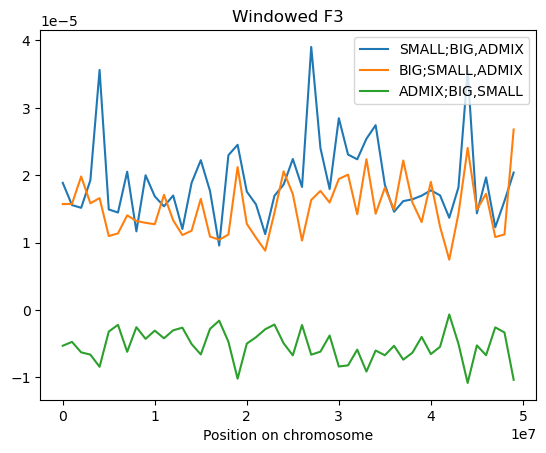

In [16]:
names_to_plot = ['SMALL;BIG,ADMIX', 'BIG;SMALL,ADMIX', 'ADMIX;BIG,SMALL']
lines = plt.plot(breakpoints[:-1], np.transpose([f3_012, f3_102, f3_201]))
plt.legend(lines, names_to_plot)
plt.xlabel("Position on chromosome")
plt.title("Windowed F3")

The green line `f3(ADMIX;BIG,SMALL)` is consistently below 0. This suggests that `ADMIX` might be an admixed population with gene flow from `BIG` and `SMALL` (which is indeed the case, since this is what we simulated).

Here are some other examples of multi-way statistics provided by `tskit`:

 - divergence
 - genetic_relatedness
 - Patterson's f2, f3, f4
 - genealogical_nearest_neighbours
 - Fst

*Exercise*. Modify the following code to compute $f_2$ statistics in 5Mb windows along the genome between the samples from populations SMALL and BIG, as well as between populations SMALL and ADMIX.

Text(0.5, 1.0, 'Windowed F2 values')

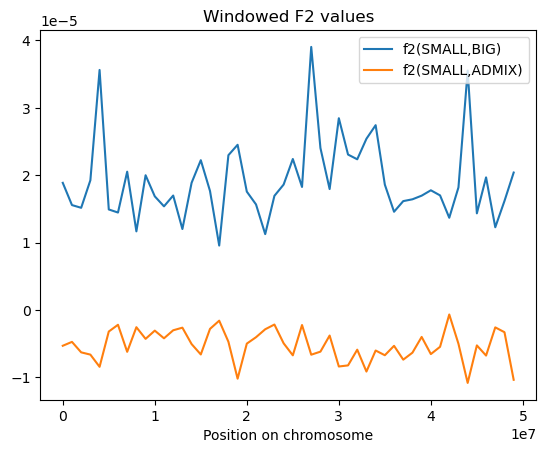

In [17]:
breakpoints = [i*1e6 for i in range(0, 50 + 1)]
f2_small_big = ts.f3(sample_sets=[ts.samples(0),
                                  ts.samples(1),
                                  ts.samples(2)],
               windows=breakpoints)
f2_small_admix = ts.f3(sample_sets=[ts.samples(2),
                                  ts.samples(1),
                                  ts.samples(0)],
               windows=breakpoints)

# Plot.
names_to_plot = ['f2(SMALL,BIG)', 'f2(SMALL,ADMIX)']
lines = plt.plot(
    breakpoints[:-1], np.transpose([f2_small_big, f2_small_admix]))
plt.legend(lines, names_to_plot)
plt.xticks()
plt.xlabel("Position on chromosome")
plt.title("Windowed F2 values")

<a id='4.2BranchStatistics'></a>
## 4.2 Branch statistics and the 'duality' of  tree-based statistics

There are several different types of randomness in genetic models that interact with each other in complex ways.
Firstly, there is randomness in the genealogical trees that are produced in a given demographic scenario.
Consider how different one of our trees looks...

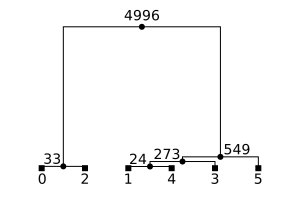

In [18]:
sts = ts.simplify(samples=[1, 11, 21, 31, 41, 51])
tree = sts.at(0)
display(SVG(tree.draw(width=300)))

from one much further along the genome:

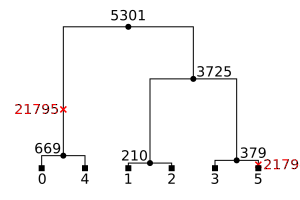

In [19]:
tree = sts.at(sts.sequence_length - 1)
display(SVG(tree.draw(width=300)))

In addition, there is randomness caused by the mutational process.

In [20]:
# Overlaid different mutations onto the same tree
tss = ts.simplify(samples=[1, 11, 21, 31, 41, 51])
mts1 = msprime.sim_mutations(tss, rate=1e-8, random_seed=1812)
mts2 = msprime.sim_mutations(tss, rate=1e-8, random_seed=1903)

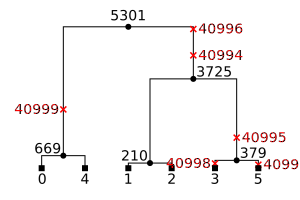

In [21]:
display(SVG(mts1.last().draw(width=300)))

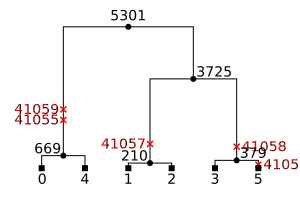

In [22]:
display(SVG(mts2.last().draw(width=300)))

When you calculate site statistics, or anything based on allele frequencies, *both* of these processes contribute to the statistical noisiness you see.

However in tree sequences, you have information about branches which allows you to bypass this latter type of mutation.
Instead of moving upwards along the trees and updating the statistic every time you come across a mutation, you can update the statistic based on the lengths of the branches.
This should have some correspondence with the *number of mutations we may expect*. (This should certainly be true in simulated datasets, where we are certain of the correctness of the underlying trees).

This is the basic idea behind the *branch statistics* in `tskit`.

Here are the diversity stats we looked at before, this time with the branch versions included. 

Text(0.5, 1.0, 'Windowed diversity (branch)')

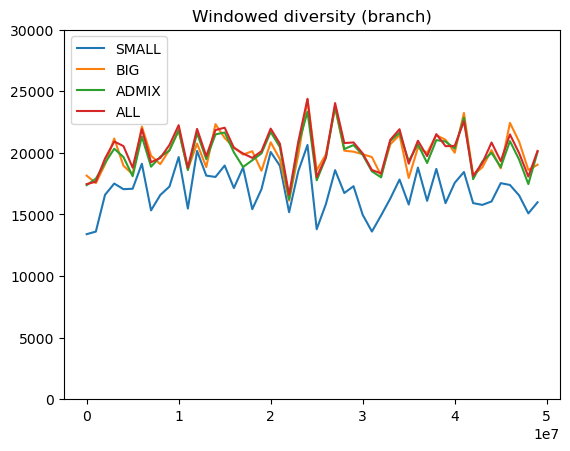

In [23]:
div_branch = ts.diversity(
    sample_sets=samples_of_interest,
    windows=breakpoints,
    mode='branch')
names_to_plot = ['SMALL', 'BIG', 'ADMIX', 'ALL']
lines = plt.plot(breakpoints[:-1], div_branch)
plt.legend(lines, names_to_plot);
plt.ylim((0,30000))
plt.title("Windowed diversity (branch)")

Text(0.5, 1.0, 'Windowed diversity (site)')

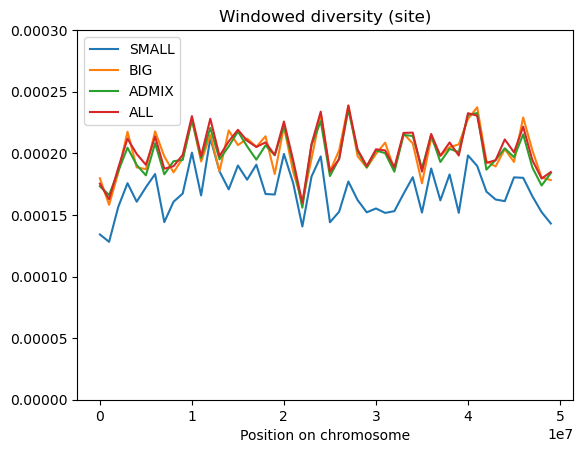

In [24]:
div_site = ts.diversity(
    sample_sets=samples_of_interest,
    windows=breakpoints,
    mode='site')
names_to_plot = ['SMALL', 'BIG', 'ADMIX', 'ALL']
lines = plt.plot(breakpoints[:-1], div_site)
plt.xlabel("Position on chromosome")
plt.legend(lines, names_to_plot)
plt.ylim((0,0.0003))
plt.title("Windowed diversity (site)")

<a id='4.3Simplify'></a>
## 4.3 Simplify

Consider two of the most common 'subset'-type operations we want to do with genomic datasets:

- Look at the data for a subset of the samples in the original dataset.
- Look at sequence/variant information at the specific sites that vary within that subsample.

`simplify` is the tree sequence version of these operations.

### The basic syntax

`simplify` requires a list of sample IDs that you wish to include in the new, smaller tree sequence.
Here, we return the tree sequence for all of the samples from population 'ADMIX' (which has a population label of `2`):

In [ ]:
ts

In [ ]:
tss = ts.simplify(ts.samples(2))
tss

We now have a smaller tree sequence holding just those 20 sample chromosomes from population 'ADMIX'.
Note that the number of sites and mutations is also reduced. This is because `simplify` has also removed all the mutations on the edges that were pruned away. Alleles arising from these mutations were only inherited by other samples, or are ancestral to everyone in this smaller subset.

Although there are fewer edges, nodes and mutations in this newer, simplified tree sequence, it's not a drastic difference. This shows the sub-linearity and efficiency of tree sequence structures. 

It turns out that operations like `simplify` are essential to generate tree sequences from forward-time simulation programs like SLiM — see [this](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006581) if you are interested.

<a id='4.4PopulationBasedAncestry'></a>
## 4.4 Population and individual-based ancestry

Why is understanding ancestry important?

 - **Demography and history:** Inference about the dates and composition of evolutionary changes and historical events.
 - **Medicine:** GWAS and risk prediction studies, admixture mapping studies.
 - **Genetic pipelines:** Phasing, imputation, genotyping errors, SNP ascertainment.
 
Suppose your genealogical ancestors can be partitioned into distinct *populations*.

 <img src="pics/worksheet4-LA.png" width="500" height="500">
 
 This is typically reported as global and local ancestry:
 
 <img src="pics/worksheet4-LA2.png" width="500" height="500">
 
 However, there are limitations to population-based notions of ancestry:
 
  - 'Populations' are often labels chosen by the researcher to make models more interpretable.
  - There is always variation within populations.
  - Different 'populations' may be relevant in different epochs.
  - Gene flow is often gradual and spatial in nature.
  - (Consider the history of population genetics in humans:) eugenics happened.
  
The alternative is to think about ancestry on the level of *individuals*.
 
 <img src="pics/worksheet4-ibd.png" width="600" height="600">
 
Both of these types of ancestry can be extracted using methods in `tskit`.

In [25]:
tss = ts.simplify(samples=[1, 11, 21, 31, 41, 51])
tss

### Population-based ancestry with `link-ancestors`

Tree sequences thus contain richly detailed information about local ancestry: any sample node that descends from a node in a given population at some location will have ancestry with the population at the location.

 <img src="pics/worksheet4-link-ancestors.png" width="600" height="600">
 
However, for realistically large and complicated simulations, recovering this information from the overall genealogies is challenging. A visually intuitive way to do this is to locate each sample haplotype on each tree and trace a path up the tree until an ancestral node from one of the populations of interest is reached.

However, this approach will be quite inefficient. Any genealogical feature that is shared between different haplotypes, or across different regions of the genome, will be processed separately for each sample and each tree. Given the substantial correlations in genealogy that typically exist between individuals, and across genomes, this approach would require many repetitive operations.

#### Step 1: Run a simulation with populations and `add_census`

By default, the tree sequences generated by `msprime` may not contain all of the ancestral nodes that are needed to extract information about local ancestry.

In [ ]:
demography = msprime.Demography()
demography.add_population(
    name="SMALL", initial_size=200)
demography.add_population(
    name="BIG", initial_size=500)
demography.add_population(
    name="ADMIX", initial_size=200)
demography.add_population(
    name="ANC", initial_size=500)
demography.add_admixture(
    time=20,
    derived="ADMIX",
    ancestral=["SMALL", "BIG"],
    proportions=[0.5, 0.5]
)
# demography.add_census(time=599.5)
demography.add_population_split(
    time=600,
    derived=["SMALL", "BIG"],
    ancestral="ANC"
)
# demography.debug()

In [ ]:
ts = msprime.sim_ancestry(
    samples={"SMALL": 0, "BIG": 0, "ADMIX" : 2},
    demography=demography,
    random_seed=1008,
    sequence_length=10000,
    recombination_rate=3e-8
)
# ts

In [ ]:
colour_map = {0:"red", 1:"blue", 2:"purple", 3:"gray"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}
for tree in ts.trees():
    print("Tree on interval:", tree.interval)
    # The code below will only work in a Jupyter notebook with SVG output enabled.
    display(SVG(tree.draw(node_colours=node_colours, width=500, height=400)))

As we discussed above, 'ancestry' only makes sense with reference to a particular time. Generally what's meant by 'ancestry' is 'where the ancestors were at some particular point in the past'.

The `add_census` method is a special demographic event that records a node on all lineages that are extant at a given time.
This is needed to simulate complete information about local ancestry.

In [ ]:
demography = msprime.Demography()
demography.add_population(
    name="SMALL", initial_size=200)
demography.add_population(
    name="BIG", initial_size=500)
demography.add_population(
    name="ADMIX", initial_size=200)
demography.add_population(
    name="ANC", initial_size=500)
demography.add_admixture(
    time=20,
    derived="ADMIX",
    ancestral=["SMALL", "BIG"],
    proportions=[0.5, 0.5]
)
demography.add_census(time=599.5)
demography.add_population_split(
    time=600,
    derived=["SMALL", "BIG"],
    ancestral="ANC"
)
# demography.debug()

In [ ]:
seq_length = 1e4
ts = msprime.sim_ancestry(
    samples={"SMALL": 0, "BIG": 0, "ADMIX" : 2},
    demography=demography,
    random_seed=1008,
    sequence_length=seq_length,
    recombination_rate=3e-8
)
# ts

In [ ]:
colour_map = {0:"red", 1:"blue", 2:"purple", 3:"gray"}
node_colours = {u.id: colour_map[u.population] for u in ts.nodes()}
for tree in ts.trees():
    print("Tree on interval:", tree.interval)
    # The code below will only work in a Jupyter notebook with SVG output enabled.
    display(SVG(tree.draw(node_colours=node_colours, width=500, height=400)))

#### Step 2: Get the census nodes

In [ ]:
census_nodes = []
for n in ts.nodes():
    if n.time == 599.5:
        census_nodes.append(n.id)
        
# census_nodes

#### Step 3: Apply link-ancestors

In [ ]:
ancestor_table = ts.tables.link_ancestors(
    samples=ts.samples(), 
    ancestors=census_nodes
)
# ancestor_table

Note that each node in the `parent` table above is one of the `census_nodes`. This is essentially what `link_ancestors` does -- it shows you directly which of your samples descend from which of the census ancestors.

#### Step 3. Replace the nodes with their population label

In [ ]:
def get_population_id(node, ts):
    return ts.tables.nodes.population[node]

local_ancestry = pd.DataFrame(
    data = {
        'left': ancestor_table.left,
        'right': ancestor_table.right,
        'population' : [ts.node(n).population for n in ancestor_table.parent],
        'child' : ancestor_table.child
    }
)

print(local_ancestry)

(If you want: here's some more advanced code to sort and squash the table...)

In [ ]:
new_sample = []
new_left = []
new_right = []
new_population = []

local_ancestry.sort_values(
    by=['child','left'], inplace=True, ignore_index=True)

for ind, row in local_ancestry.iterrows():
    if ind > 0 and row['left']==new_right[-1] and row['population'] == new_population[-1] and row['child'] == new_sample[-1]:
        new_right[-1] = row['right']
    else:
        new_sample.append(row['child'])
        new_left.append(row['left'])
        new_right.append(row['right'])
        new_population.append(row['population'])
        
squashed_ancestry_table = pd.DataFrame({
    'child': [int(i) for i in new_sample],
    'left' : new_left,
    'right': new_right,
    'population' : [int(p) for p in new_population]
})

squashed_ancestry_table

We can use this information to plot local ancestry in each of our samples, for instance.

In [ ]:
def plot_ancestry_chunk(row, chrom):
    l = row.left/seq_length
    r = row.right/seq_length
    p = row.population
    if int(p) == 0:
        c = 'blue'
    elif int(p) == 1:
        c = 'red'
    print('p is', p)
    chunk = np.array([[l, 0], [r, 0], [r, 1], [l, 1]])
    chrom.add_patch(Polygon(xy=chunk, color = c))

In [ ]:
chrom_labels = {0: 'chr0', 1: 'chr1'}
colors = ['red', 'blue']
length = ts.sequence_length

fig, (chr0, chr1) = plt.subplots(2, figsize=(10,2))
fig.suptitle('Ancestry in admixed individual')
fig.frameon=False
fig.legend(
    handles = [Polygon(xy = np.array([[0,0],[0,1],[1,1],[1,0]]), color = 'blue'),
              Polygon(xy = np.array([[0,0],[0,1],[1,1],[1,0]]), color = 'red')],
    labels = ['SMALL', 'BIG'],
    loc = 'right'
)
for ind, row in squashed_ancestry_table.iterrows():
    if row.child > 1:
        break
    chunk = np.array([[row.left/length, 0], [row.right/length, 0],
                      [row.right/length, 1], [row.left/length, 1]])
    if chrom_labels[row.child] == 'chr0':
        chr0.add_patch(Polygon(xy=chunk, color = colors[int(row.population)]))
    elif chrom_labels[row.child] == 'chr1':
        chr1.add_patch(Polygon(xy=chunk, color = colors[int(row.population)]))

chr0.set_ylabel('Chrom 0')
chr0.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
chr1.set_xticks(ticks= [0.2, 0.4, 0.6, 0.8, 1.0], labels=[i*seq_length/5 for i in range(0, 5)])
chr1.set_xlabel('Chromosomal position (bases)')
chr1.set_ylabel('Chrom 1')
chr1.tick_params(left=False, labelleft=False)
    

Consider re-running the code in this section with a larger sequence length to see a more interesting pattern of ancestry. (You might want to comment out the plotting code...)

### Individual-based ancestry with `ibd-segments`

See [this](https://tskit.dev/tskit/docs/stable/ibd.html?highlight=ibd%20segments) preliminary tutorial and documentation [here](https://tskit.dev/tskit/docs/stable/ibd.html?highlight=ibd%20segments).